In [1]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
batch_size = 32  # Batch size for training.
epochs = 20  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 16000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

In [0]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [0]:
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [0]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [12]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 16000
Number of unique input tokens: 73
Number of unique output tokens: 101
Max sequence length for inputs: 17
Max sequence length for outputs: 59


In [0]:
input_token_index = {char:i for i, char in enumerate(input_characters)}
target_token_index = {char:i for i, char in enumerate(target_characters)}

In [0]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

decoder_target_data = np.zeros_like(decoder_input_data, dtype='float32')

In [15]:
encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((16000, 17, 73), (16000, 59, 101), (16000, 59, 101))

In [0]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
        
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t-1, target_token_index[char]] = 1.

In [0]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))

encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 73)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 101)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 337920      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  366592      input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

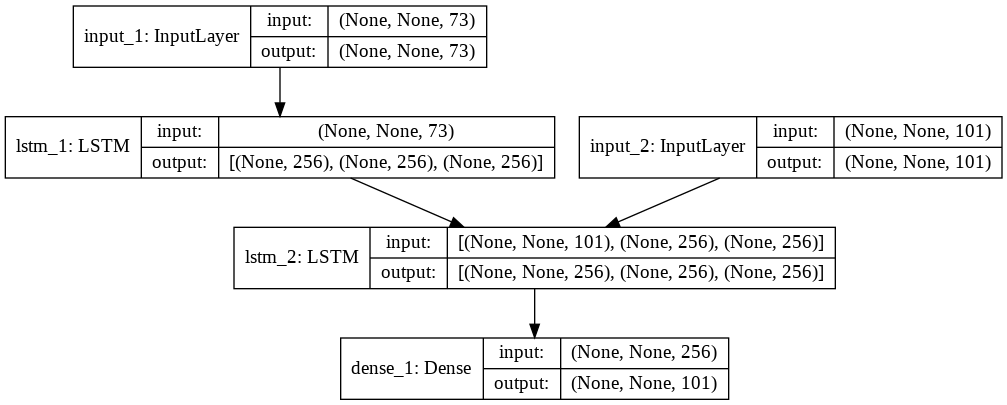

In [37]:
from keras.utils import plot_model
import IPython

plot_model(model, show_shapes=True, show_layer_names=True)
IPython.display.Image('model.png')

In [26]:
try:
    hist = model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_target_data,
          batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True)
except(KeyboardInterrupt):
    print('\nTraning stoped')

Train on 12800 samples, validate on 3200 samples
Epoch 1/20
12800/12800 [==============================] - 54s 4ms/step - loss: 0.5378 - val_loss: 0.6311
Epoch 2/20
12800/12800 [==============================] - 53s 4ms/step - loss: 0.4810 - val_loss: 0.5883
Epoch 3/20
12800/12800 [==============================] - 53s 4ms/step - loss: 0.4417 - val_loss: 0.5506
Epoch 4/20
12800/12800 [==============================] - 53s 4ms/step - loss: 0.4109 - val_loss: 0.5259
Epoch 5/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3853 - val_loss: 0.5091
Epoch 6/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3636 - val_loss: 0.4960
Epoch 7/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3444 - val_loss: 0.4857
Epoch 8/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3272 - val_loss: 0.4739
Epoch 9/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.3119 - val_loss: 0.4704
Epoch 

In [27]:
try:
    hist = model.fit(x=[encoder_input_data, decoder_input_data], y=decoder_target_data,
          batch_size=batch_size, epochs=epochs, initial_epoch=14, validation_split=0.2, shuffle=True)
except(KeyboardInterrupt):
    print('\nTraning stoped')

Train on 12800 samples, validate on 3200 samples
Epoch 15/20
12800/12800 [==============================] - 53s 4ms/step - loss: 0.2441 - val_loss: 0.4574
Epoch 16/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.2350 - val_loss: 0.4592
Epoch 17/20
12800/12800 [==============================] - 52s 4ms/step - loss: 0.2263 - val_loss: 0.4612
Epoch 18/20
10464/12800 [=======================>......] - ETA: 8s - loss: 0.2171
Traning stoped


In [0]:
# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [30]:
model.save('char_level_s2s.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [0]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [32]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 73)          0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 256), (None, 256) 337920    
Total params: 337,920
Trainable params: 337,920
Non-trainable params: 0
_________________________________________________________________


In [33]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 101)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 256),  366592      input_2[0][0]                    
                                                                 input_3[0][0]                    
          

In [0]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = {i:char for char, i in input_token_index.items()}
reverse_target_char_index = {i:char for char, i in target_token_index.items()}

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [36]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Sonnez !

-
Input sentence: Hi.
Decoded sentence: Asseyez-vous !

-
Input sentence: Run!
Decoded sentence: Souvez !

-
Input sentence: Run!
Decoded sentence: Souvez !

-
Input sentence: Wow!
Decoded sentence: Bous y aller !

-
Input sentence: Fire!
Decoded sentence: Ouvrez votre peux !

-
Input sentence: Help!
Decoded sentence: Salut !

-
Input sentence: Jump.
Decoded sentence: Buelle cher vous !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Vas-y !

-
Input sentence: Go on.
Decoded sentence: Vas-y !

-
Input sentence: Go on.
Decoded sentence: Vas-y !

-
Input sentence: Hello!
Decoded sentence: Va la chercher !

-
Input sentence: Hello!
Decoded sentence: Va la chercher !

-
Input sentence